In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [3]:
%matplotlib inline
import torchvision
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.utils import other_classes, set_log_level
from cleverhans.utils_pytorch import convert_pytorch_model_to_tf
from cleverhans.model import CallableModelWrapper
import numpy as np
import tensorflow as tf
from tqdm import tqdm

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/cumeo/anaconda3/envs/newlogic/lib

In [4]:
test_data = torchvision.datasets.MNIST('../mnist/', train=False, 
                                       transform=torchvision.transforms.ToTensor())
testloader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

In [5]:
batch_x, batch_y = next(iter(testloader))

In [7]:
net = torch.load('../output/ablation-mnist-models/attempt0/relu.pkl', map_location=torch.device('cpu'))

In [8]:
net

CNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [9]:
def show_image(ax, imgs, i=None):
    i = i or np.random.randint(len(imgs))
    img = imgs[i].permute(1,2,0)
    means, stds = cifar_stats
    means = torch.tensor(means).reshape(1,1,3)
    stds = torch.tensor(stds).reshape(1,1,3)
    img_unnormalized = img * stds + means
    ax.imshow(img_unnormalized.clamp(0, 1))

In [10]:
def predict(net, x):
    probs, _ = net(x)
    prop_top_class, top_class = probs.max(axis=1)
    top_class[prop_top_class <= 0.2] = -1
    return top_class

In [11]:
def show_image_and_probs(imgs):
    assert imgs.shape[0] == 1
    plt.axis('off')
    show_image(plt, imgs)
    probs = torch.softmax(net(imgs)[0], dim=1)[0]
    probs_str = ', '.join('%d=%.2f' %(c,p) for c, p in enumerate(probs))
    print(probs_str)

In [12]:
preds = predict(net, batch_x)

In [13]:
(preds == batch_y).float().mean()

tensor(0.9890)

In [14]:
attack_func = BasicIterativeMethod
default_attack_params = {
    'ord': np.inf, 'eps': 0.2, 
    'nb_iter': 5, 'eps_iter': .1 
}
attack_params = dict(default_attack_params)
attack_params.update({
    'clip_min': 0., 'clip_max': 1.,
})

In [15]:
def onehot(y): 
    y = torch.tensor(y)
    return torch.nn.functional.one_hot(y, 10).numpy().astype(np.int32)

In [16]:
%%time
with tf.Session() as sess:
    torch_model = lambda x: net(x)[0] # [0]: convert to standard format
    tf_model_fn = convert_pytorch_model_to_tf(torch_model, out_dims=10)    
    cleverhans_model = CallableModelWrapper(tf_model_fn, output_layer='logits')
    cleverhans_model.nb_classes = 10 

    nchannels, img_rows, img_cols = batch_x.shape[1:]
    x = tf.placeholder(tf.float32, shape=(None, nchannels, img_rows, img_cols))
    y = tf.placeholder(tf.int32, shape=(None,))
    attack_params['y'] = onehot(batch_y)
    attack_model = attack_func(cleverhans_model, sess=sess)
    clean_preds_op = tf_model_fn(x)
    preds_op = tf_model_fn(x)
    advs = attack_model.generate_np(batch_x.numpy(), **attack_params)

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
[INFO 2020-06-14 00:37:32,279 cleverhans] Constructing new graph for attack BasicIterativeMethod


CPU times: user 6.12 s, sys: 843 ms, total: 6.97 s
Wall time: 4.52 s


In [17]:
advs = torch.tensor(advs)

In [18]:
adv_preds = predict(net, advs)

In [19]:
(adv_preds == batch_y).float().mean()

tensor(0.0440)

0=0.00, 1=0.00, 2=0.00, 3=0.00, 4=0.00, 5=0.00, 6=0.00, 7=1.00, 8=0.00, 9=0.00


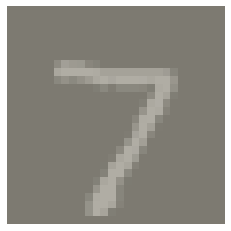

In [20]:
natural = batch_x[[0]]
show_image_and_probs(natural)

0=0.00, 1=0.00, 2=0.02, 3=0.00, 4=0.00, 5=0.00, 6=0.00, 7=0.10, 8=0.00, 9=0.88


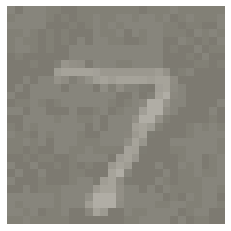

In [21]:
adv_member = advs[[0]]
show_image_and_probs(adv_member)

0=0.00, 1=0.00, 2=0.00, 3=0.00, 4=0.00, 5=0.00, 6=0.00, 7=0.00, 8=0.00, 9=1.00


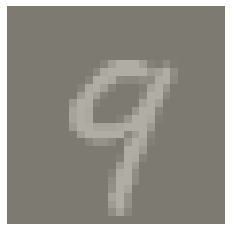

In [28]:
true_member = batch_x[batch_y==9][[2]]
show_image_and_probs(true_member)

In [23]:
torch.norm(natural-adv_member, p=np.inf)

tensor(0.2000)

In [24]:
torch.norm(true_member-adv_member, p=np.inf)

tensor(1.)